# Part 1: Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Read in the data
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
# Initial check for data quality: No null values - good!
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [4]:
# Resample in 15 minute time intervals
logins_df.set_index('login_time', inplace=True)
logins_df['count'] = 1
logins_df = logins_df.resample('15T').sum()

logins_df.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


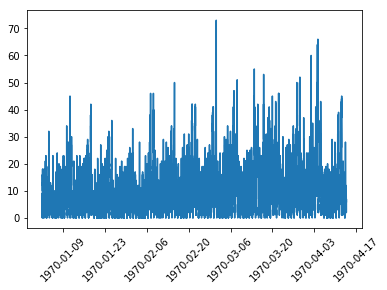

In [5]:
# Show the entire series
plt.plot(logins_df)
plt.xticks(rotation=45);

We see here that we have some series overplotting, but that there are clear areas where there are trends. This is characterized by a darker line on the plot. What we can do now is split the data by month and see if we can more easily find trends.

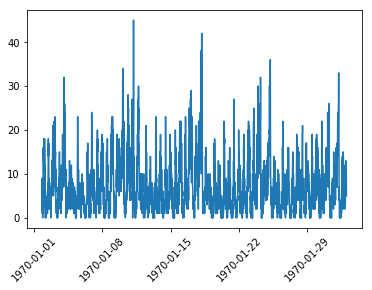

In [6]:
# Plot of the first month (january) of time series data
plt.plot(logins_df['1970-01-01': '1970-02-01'])
plt.xticks(rotation=45);

We still see a bit of overplotting, so let's dig deeper. Interestingly, it looks like there is an increasing trend over the week in addition to weekly cycles. For each month, let's split the data into each day of the week and aggregate from there.

In [7]:
# Re-read in the data
logins_df = pd.read_json('logins.json')
logins_df = logins_df.set_index('login_time')
#logins_df.reset_index(drop=False, inplace=True)

# Split by month into new dataframes
jan_df = logins_df['1970-01-01': '1970-01-31']
jan_df.reset_index(drop=False, inplace=True)

feb_df = logins_df['1970-02-01': '1970-02-28']
feb_df.reset_index(drop=False, inplace=True)

mar_df = logins_df['1970-03-01': '1970-03-31']
mar_df.reset_index(drop=False, inplace=True)

apr_df = logins_df['1970-04-01': '1970-04-30']
apr_df.reset_index(drop=False, inplace=True)

# Show example
print('January df sample:\n\n{}'.format(jan_df.head()))

January df sample:

           login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21


In [8]:
# Create new day of week feature to aggregate on
month_list = [jan_df, feb_df, mar_df, apr_df]

for month_df in month_list:
    month_df['day_of_week'] = month_df['login_time'].map(lambda x: x.weekday())
    
# Show example
print('January df sample:\n\n{}'.format(jan_df.head()))

January df sample:

           login_time  day_of_week
0 1970-01-01 20:13:18            3
1 1970-01-01 20:16:10            3
2 1970-01-01 20:16:37            3
3 1970-01-01 20:16:36            3
4 1970-01-01 20:26:21            3


In [9]:
# Define a function to color each day of the week when plotting
def show_trends(df, title, weekends=False):
    new_df = df.set_index('login_time')

    for day in sorted(list(new_df['day_of_week'].unique())):

        temp = new_df[new_df['day_of_week'] == day]
        temp.drop('day_of_week', axis=1, inplace=True)
        temp['count'] = 1
        temp = temp.resample('15T').sum()
        
        if weekends == True:
            if day in [0,1,2,3,4]:
                color = 'blue'
            else:
                color = 'red'
            plt.plot(temp, color=color)
            plt.title(title)
            plt.xticks(rotation=45)
         
        else:
            plt.plot(temp)
            plt.title(title)
            plt.xticks(rotation=45)

Now we can really see whether there are any daily or weekly trends. Let's start with January:

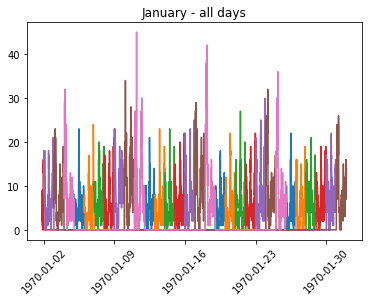

In [10]:
show_trends(jan_df, title='January - all days')

We can see that the first day of the month, a Thursday, in teal is the start of the series. We then see that there tends to be an increasing trend from every Monday, in dark blue, to every Sunday, in black. Further, the gold and black lines (indicating Saturday and Sunday, respectively) tend to be the highest of their respective weeks. We infer that there are more users as the week goes on, and activity seems to reset every Monday.

To see this even more clearly, let's isolate the weekends. Below weekends are in red whereas weekdays are in blue:

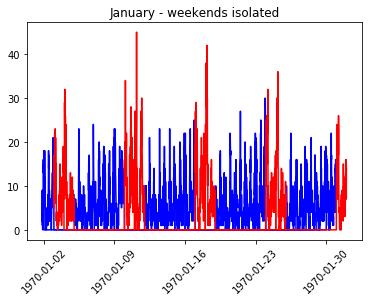

In [11]:
show_trends(jan_df, title='January - weekends isolated', weekends=True)

Now it is more clear that weekends are peak times for activity for January. Let's continue with the rest of the months below:

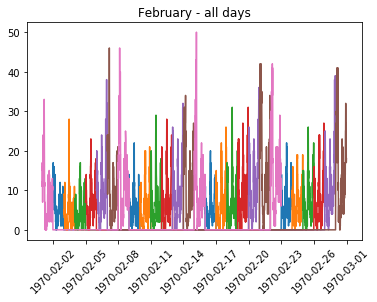

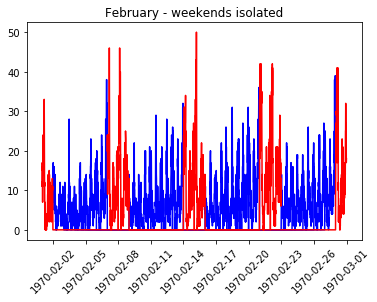

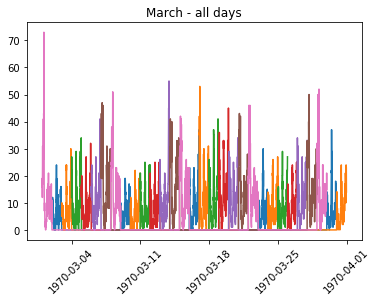

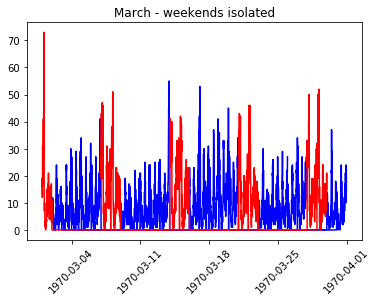

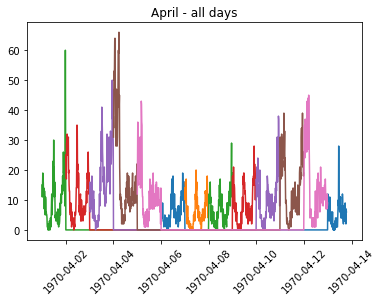

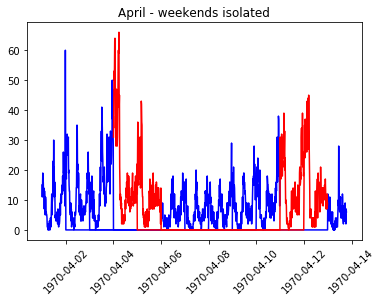

In [12]:
count = 0
month_names = ['February', 'March', 'April']

for month in month_list[1:]:
    title = month_names[count] + ' - all days'
    show_trends(month, title=title)
    plt.show();
    
    title = month_names[count] + ' - weekends isolated'
    show_trends(month, title=title, weekends=True)
    plt.show();
    
    count += 1

We see that the trends identified in January hold most of the time for February, March, and April where we see most of the deviation from this trend in March, but there is still a good amount of weekly cycle present. It is worth noting two other things: 1) We do not have all of April's data, which is why we only see two weekends represented and a more drawn out plot, and 2) all graph's y-axes are not on the same scale. With regard to the second point, January has a scale 0-45, February a scale 0-50, March a scale 0-80, and April a scale 0-70. We have to keep in mind this fact to determine that some months may have higher rates of activity than others.

# Part 2: Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.  
  
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:  
 + how you will implement the experiment.
 + what statistical test(s) you will conduct to verify the significance of the observation. 
 + how you would interpret the results and provide recommendations to the city operations team along with any caveats.

### Solution:

With regard to the key measure of success, I would choose a metric that describes the percentage of time a driver spends in either city. At this point, since the drivers tend to be exclusive to both cities, the metric for the average Gotham driver would look something like 100% time in Gotham and 0% time in Metropolis. In a perfectly successful experiment, we would see the metric shift closer to 50% time in Gotham and 50% time in Metropolis. In a less successful experiment, we would see the metric shift closer to 75% time in Gotham and 25% time in Metropolis. If the metric for the average Gotham driver flips to favor time in Metropolis, there is something wrong and we have incentivized time in Metropolis too much and we may see the average Metropolis driver stay in Metropolis and vice versa. Using a metric such as this one allows us to track real activity in the drivers of both cities and the maximization of such a metric results in a balance of time in both cities.
  
We should also keep in mind revenue as a secondary metric to look at, since this is usually the main reason for solving a business problem. Using revenue as a main metric, however, can be problematic because the real reasons for movements in revenue are not always apparent. Maximizing revenue may be good for short-term bottom line results, but not great for long-term growth. For example, seeking to maximize revenue may result in incentives to drive in only Gotham or only Metropolis due to increased fares in either city, which would cause us to alienate an entire group of drivers and customers.

I would set up the experiment in the following way:  
  
Current scenario: Average time split for the average Gotham driver is close to 100% Gotham, 0% Metropolis. Average time split for the average Metropolis driver is close to 100% Metropolis, 0% Gotham.  
Goal: Push the average time split for both the average Gotham driver and average Metropolis closer to 50% Gotham, 50% Metropolis.   
  
The experiment consists of offering full reimbursements to all toll costs, and can be tested during two times of the year: 1) when it is easy to drive (summer) and 2) when it is difficult to drive (winter). For the purposes of this challenge, let's focus on a typical summer month when the experiment will be run for one month.  
  
We can measure the results of the experiment with a one-tailed z-test where we can test whether the average Gotham driver's time spent in Gotham is meaningfully below 100% and whether the average Metropolis driver's time spent in Metropolis is meaningully below 100%. Alternatively, we could also test whether either time spent is meaningfully above 0% outside of a driver's native city. A one-tailed test is appropriate since we want to test whether the average percent of time has changed to either above 0% or below 100% (depending on the scenario we want to test as described previously). A z-test is appropriate because we can obtain a rather large sample size (easily >30) and we likely know or can find the population's standard deviation under normal operation.  
  
We can interpret the results in the form of a confidence interval. To be safe, a 95% confidence interval could be useful. In this way, we can present our findings such as: We are 95% confident that the mean percent of time the average Gotham driver spends driving in Gotham has dropped to 75% give or take 5%. In this way we can easily show whether the test worked and whether drivers from each city are spending more time outside of their native cities. Two caveats, as described when exploring metrics, might be that:
1. Profits may have dropped depending on how many drivers move between each city. It is possible that, since demand for drivers has not been increased, profits will drop because the company is now reimbursing toll expenses while not increasing revenue. This may be of lesser concern because our main goal is to incentivize drivers to operate in both cities.  
2. We may find that we incentivised too well. For example, if we are 95% confident that the mean percent of time the average Gotham driver spends driving in Gotham has dropped to 35% give or take 5%, we could see that the metric for Metropolis drivers has not moved meaningfully. In this case, we should incentivize differently since it may not always be a good thing that the metrics have move in a statistically significant way.

# Part 3: Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.  
  
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.  
  
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.  
  
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

# Data description
● city: city this user signed up in  
● phone: primary device for this user  
● signup_date: date of account registration; in the form ‘YYYY MM DD’  
● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’  
● avg_dist: the average distance in miles per trip taken in the first 30 days after signup  
● avg_rating_by_driver: the rider’s average rating over all of their trips  
● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips  
● surge_pct: the percent of trips taken with surge multiplier > 1  
● avg_surge: The average surge multiplier over all of this user’s trips  
● trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up  
● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise  
● weekday_pct: the percent of the user’s trips occurring during a weekday

## Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice).

In [13]:
# Read in the data
import json

file = open('ultimate_data_challenge.json', 'r')
df = pd.DataFrame(json.load(file))
file.close()

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [14]:
# Are there any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [15]:
# Since the date fields have been read in as 'object' data types, we should convert them to proper datetime format
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [16]:
# Do the features take values we might expect?
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


We read in the data and inspected it. We see that while the numerical features take values we might expect (percents are between 0 and 100, for example), there are a few features that are missing values. Let's take a closer look:

In [17]:
# Look closer at missing values - how many exactly?

for column in list(df.columns):
    num_missing = len(df[df[column].isnull()])
    if num_missing != 0:
        print('There are {} missing values in {}'.format(num_missing, column))

There are 201 missing values in avg_rating_by_driver
There are 8122 missing values in avg_rating_of_driver
There are 396 missing values in phone


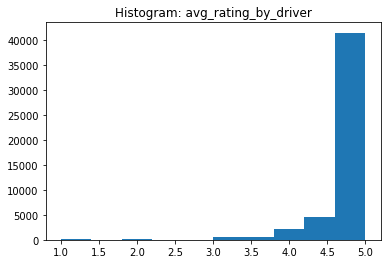

In [18]:
# Let's look at the distribution of values for avg_rating_by_driver

plt.hist(df[np.logical_not(df['avg_rating_by_driver'].isnull())]['avg_rating_by_driver'])
plt.title('Histogram: avg_rating_by_driver')
plt.show;

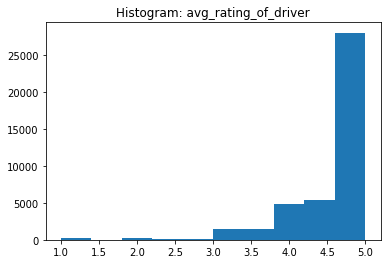

In [19]:
# Let's look at the distribution of values for avg_rating_of_driver

plt.hist(df[np.logical_not(df['avg_rating_of_driver'].isnull())]['avg_rating_of_driver'])
plt.title('Histogram: avg_rating_of_driver')
plt.show;

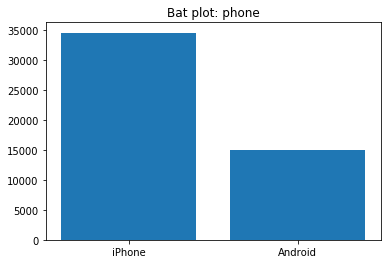

In [20]:
# Let's look at the distribution of values for phone

plt.bar([1,2], df[np.logical_not(df['phone'].isnull())]['phone'].value_counts(), align='center')
plt.xticks([1,2], ['iPhone', 'Android'])
plt.title('Bat plot: phone')
plt.show;

The first two features are numerical in nature, so we visualize with a histogram. Seeing as they are highly skewed, we will fill in the missing values using the mean so that we can preserve it. It is worth noting that this approach ignores any relationships on the instance level, and another solution would be to fit a regressor to the data and impute predictively. The third feature is nominal and is weighted toward 'iPhone', and so we will fill in missing values with this value as well as its prior probability is highest. Alternatively, here too we could fit a classifier to the data and impute predictively.

In [21]:
# Fill in missing values

df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('iPhone', inplace=True)

In [22]:
# Did it work?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     50000 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


Now that missing values have been taken care of, let's see if we have any outliers in our data by using boxplots:

In [23]:
# Make lists of each feature type for easy plotting

numerical_features = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 
                      'avg_surge', 'surge_pct', 'trips_in_first_30_days', 'weekday_pct']

categorical_features = ['city', 'phone', 'ultimate_black_user']

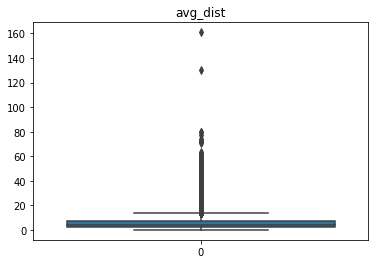

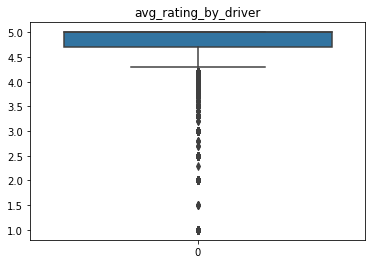

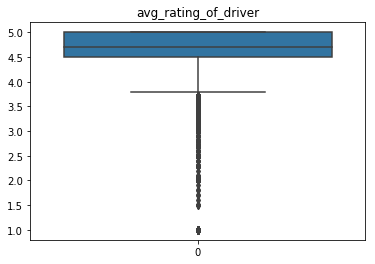

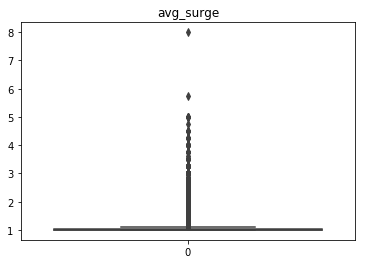

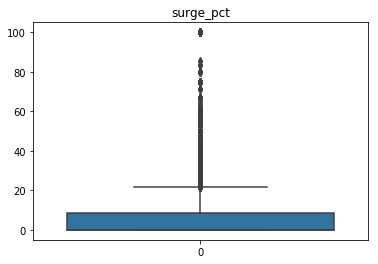

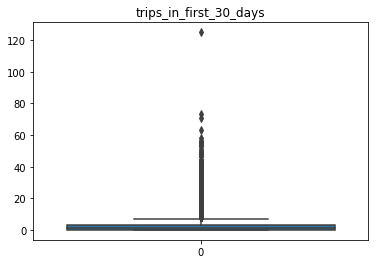

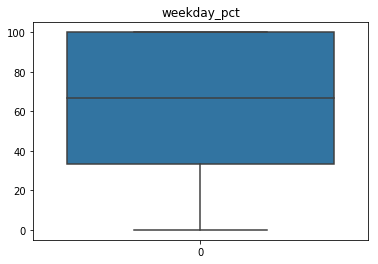

In [24]:
# Show boxplots of numerical features
import seaborn as sns

for feature in numerical_features:
    sns.boxplot(data=df[feature])
    plt.title(feature)
    plt.show();

We can see that there are outliers present in all numerical features except for weekday_pct. We will continue by excluding rows that contain features that take values more than 3 standard deviations away from the mean.

In [25]:
# Filter out rows with features that have values more than 3 standard deviations from the mean
df = df[np.abs(df['avg_dist']-df['avg_dist'].mean())<=(3*df['avg_dist'].std())]
df = df[np.abs(df['avg_rating_by_driver']-df['avg_rating_by_driver'].mean())<=(3*df['avg_rating_by_driver'].std())]
df = df[np.abs(df['avg_rating_of_driver']-df['avg_rating_of_driver'].mean())<=(3*df['avg_rating_of_driver'].std())]
df = df[np.abs(df['avg_surge']-df['avg_surge'].mean())<=(3*df['avg_surge'].std())]
df = df[np.abs(df['surge_pct']-df['surge_pct'].mean())<=(3*df['surge_pct'].std())]
df = df[np.abs(df['trips_in_first_30_days']-df['trips_in_first_30_days'].mean())<=(3*df['trips_in_first_30_days'].std())]
df.reset_index(drop=True, inplace=True)

In [26]:
# How much data do we have now?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44666 entries, 0 to 44665
Data columns (total 12 columns):
avg_dist                  44666 non-null float64
avg_rating_by_driver      44666 non-null float64
avg_rating_of_driver      44666 non-null float64
avg_surge                 44666 non-null float64
city                      44666 non-null object
last_trip_date            44666 non-null datetime64[ns]
phone                     44666 non-null object
signup_date               44666 non-null datetime64[ns]
surge_pct                 44666 non-null float64
trips_in_first_30_days    44666 non-null int64
ultimate_black_user       44666 non-null bool
weekday_pct               44666 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 3.8+ MB


Now that we've identified outliers in the data, let's determine if all cateogorical features take appropriate values (i.e. look for typos):

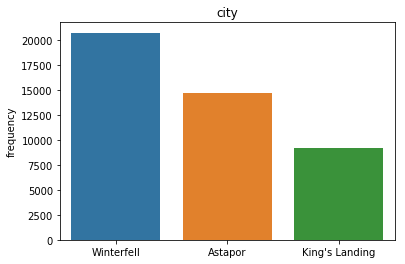

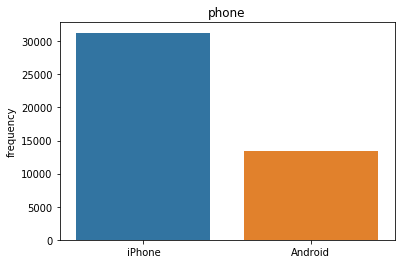

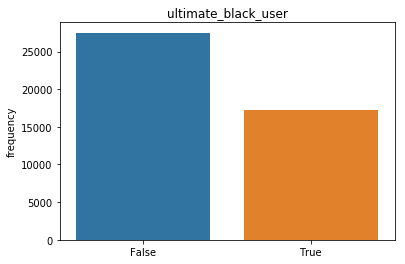

In [27]:
# Create box plots of all categorical, non-date data

for feature in categorical_features:
    sns.barplot(x = list(df[np.logical_not(df[feature].isnull())][feature].value_counts().index), 
                y = df[np.logical_not(df[feature].isnull())][feature].value_counts())
    plt.title(feature)
    plt.ylabel('frequency')
    plt.show();

We see that all non-date categorical features take values we would expect and so we do not need to clean these any further. Next, we will explore correlations to determine if there is any redundancy in the data or highly predictive features:

In [28]:
# Show the correlation matrix
corr_matrix = df.corr()
corr_matrix

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,1.000000,0.113764,0.036985,-0.125715,-0.141120,-0.157064,0.032364,0.106505
avg_rating_by_driver,0.113764,1.000000,0.108811,-0.054707,-0.045886,-0.136598,-0.020618,0.019580
avg_rating_of_driver,0.036985,0.108811,1.000000,-0.030831,-0.012833,-0.058875,-0.011233,0.004661
avg_surge,-0.125715,-0.054707,-0.030831,1.000000,0.849852,0.150471,-0.016889,-0.091408
surge_pct,-0.141120,-0.045886,-0.012833,0.849852,1.000000,0.145407,-0.035394,-0.103303
trips_in_first_30_days,-0.157064,-0.136598,-0.058875,0.150471,0.145407,1.000000,0.082045,0.025849
ultimate_black_user,0.032364,-0.020618,-0.011233,-0.016889,-0.035394,0.082045,1.000000,0.021997
weekday_pct,0.106505,0.019580,0.004661,-0.091408,-0.103303,0.025849,0.021997,1.000000


In [29]:
# Filter to see if there are any features correlated at above 0.50 or below -0.50
corr_matrix[(abs(corr_matrix) >= 0.50) & (abs(corr_matrix) < 1.0)]

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
avg_dist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_by_driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_rating_of_driver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_surge,NaN,NaN,NaN,NaN,0.849852,NaN,NaN,NaN
surge_pct,NaN,NaN,NaN,0.849852,NaN,NaN,NaN,NaN
trips_in_first_30_days,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ultimate_black_user,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday_pct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that surge_pct and avg_surge are highly correlated with eachother at 0.849852, and this makes sense given these two features are highly related to there being a surge or not. Since there are not too many features in this dataset, we will keep these two features.  
  
### Finally, what fraction of observed users were retained?

In [30]:
# When was the last trip date in the dataset?
sorted(df['last_trip_date'].unique())[-10:]

[numpy.datetime64('2014-06-22T00:00:00.000000000'),
 numpy.datetime64('2014-06-23T00:00:00.000000000'),
 numpy.datetime64('2014-06-24T00:00:00.000000000'),
 numpy.datetime64('2014-06-25T00:00:00.000000000'),
 numpy.datetime64('2014-06-26T00:00:00.000000000'),
 numpy.datetime64('2014-06-27T00:00:00.000000000'),
 numpy.datetime64('2014-06-28T00:00:00.000000000'),
 numpy.datetime64('2014-06-29T00:00:00.000000000'),
 numpy.datetime64('2014-06-30T00:00:00.000000000'),
 numpy.datetime64('2014-07-01T00:00:00.000000000')]

Based on the last trip date in the dataset of 7/1/2014, it looks like the data was pulled on July 1st, 2014. By definition, retained users made a trip within the last 30 days of this date. Let's see how many users have been retained:

In [31]:
print('{:.2f}% of users have taken a trip on or after June 1st, 2014 and are considered \'retained\'.'\
      .format(len(df[df['last_trip_date'] >= '2014-06-01'])/len(df)*100))

38.59% of users have taken a trip on or after June 1st, 2014 and are considered 'retained'.


## Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

We begin by creating the target variable for a binary classification of retained or not retained:

In [32]:
# Create the target variable, retained

df['retained'] = np.nan
df.loc[df['last_trip_date'] >= '2014-06-01', 'retained'] = 1
df.loc[df['last_trip_date'] < '2014-06-01', 'retained'] = 0

df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1.0
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0.0


Since we have created the target feature based on the last_trip_date feature, we need to drop last_trip_date.

In [33]:
# Drop last_trip_date
df.drop('last_trip_date', axis=1, inplace=True)

We will move forward by splitting this data into train and test sets, and model the data with a decision tree classifier. In addition, the decision tree does not handle data if it is not numerical in nature. We must drop all datetime features and one-hot-encode any categorical features.  
  
The decision tree is a good choice in this scenario due to its interpretability and ease of finding the most predictive features of retention. In addition, the decision tree gives the best baseline accuracy compared to logistic regression, naive bayes, k-nearest-neighbors, random forest, bagged random forest, and bagged random (extra) tree classifiers.

In [34]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

In [35]:
# Drop other datetime features
df.drop('signup_date', axis=1, inplace=True)

In [36]:
# One-hot-encode all categorical features
df_encoded = pd.get_dummies(df, columns = ['city', 'phone', 'ultimate_black_user'])

df_encoded.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,retained,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,3.67,5.0,4.7,1.10,15.4,4,46.2,1.0,0,1,0,0,1,0,1
1,8.26,5.0,5.0,1.00,0.0,0,50.0,0.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,0.0,3,100.0,0.0,1,0,0,0,1,1,0
3,2.36,4.9,4.6,1.14,20.0,9,80.0,1.0,0,1,0,0,1,0,1
4,3.13,4.9,4.4,1.19,11.8,14,82.4,0.0,0,0,1,1,0,1,0


In [37]:
# Split into train and test sets

train, test = train_test_split(df_encoded, test_size=.30, 
                               random_state=42, stratify=df_encoded['retained'])

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

print('Train shape: {}\n Test shape: {}'.format(train.shape, test.shape))

Train shape: (31266, 15)
 Test shape: (13400, 15)


In [38]:
# Perform cross validation on the training set

from sklearn import cross_validation

target = train['retained']
train = train.drop('retained', axis=1)

clf = DecisionTreeClassifier(max_depth=4)

cv = cross_validation.KFold(len(train), n_folds=10)

cv_count = 1
for traincv, testcv in cv:  
        preds = clf.fit(train.loc[list(traincv),:], 
                        target.loc[list(traincv),]).predict(train.loc[list(testcv),:])
        
        false_positive_rate, true_positive_rate, thresholds = roc_curve(target.loc[testcv,], preds)

        print('Round {} CV\nAccuracy: {:.2f}\nAUC: {:.4f}\nConfusion Matrix:\n{}\n\n'\
                  .format(cv_count, accuracy_score(target.loc[testcv,], preds)*100, 
                          auc(false_positive_rate, true_positive_rate),
                          confusion_matrix(target.loc[testcv,], preds)))
        cv_count += 1

C:\Users\vibas\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Round 1 CV
Accuracy: 73.90
AUC: 0.7243
Confusion Matrix:
[[1521  412]
 [ 404  790]]


Round 2 CV
Accuracy: 73.90
AUC: 0.7273
Confusion Matrix:
[[1472  397]
 [ 419  839]]


Round 3 CV
Accuracy: 75.38
AUC: 0.7405
Confusion Matrix:
[[1537  390]
 [ 380  820]]


Round 4 CV
Accuracy: 74.64
AUC: 0.7298
Confusion Matrix:
[[1535  370]
 [ 423  799]]


Round 5 CV
Accuracy: 74.22
AUC: 0.7269
Confusion Matrix:
[[1526  396]
 [ 410  795]]


Round 6 CV
Accuracy: 75.31
AUC: 0.7343
Confusion Matrix:
[[1576  364]
 [ 408  779]]


Round 7 CV
Accuracy: 75.18
AUC: 0.7407
Confusion Matrix:
[[1528  416]
 [ 360  822]]


Round 8 CV
Accuracy: 72.20
AUC: 0.7062
Confusion Matrix:
[[1502  449]
 [ 420  755]]


Round 9 CV
Accuracy: 75.46
AUC: 0.7365
Confusion Matrix:
[[1559  340]
 [ 427  800]]


Round 10 CV
Accuracy: 74.38
AUC: 0.7317
Confusion Matrix:
[[1502  410]
 [ 391  823]]




In [39]:
# Train the model on the full training data and test on the test set
final_clf = clf.fit(train, target)

test_target = test['retained']
test = test.drop('retained', axis=1)

test_preds = final_clf.predict(test)



print('Test set accuracy: {:.2f}\nConfusion Matrix:\n{}'\
          .format(accuracy_score(test_target, test_preds)*100, 
                  confusion_matrix(test_target, test_preds)))

Test set accuracy: 74.11
Confusion Matrix:
[[6479 1750]
 [1719 3452]]


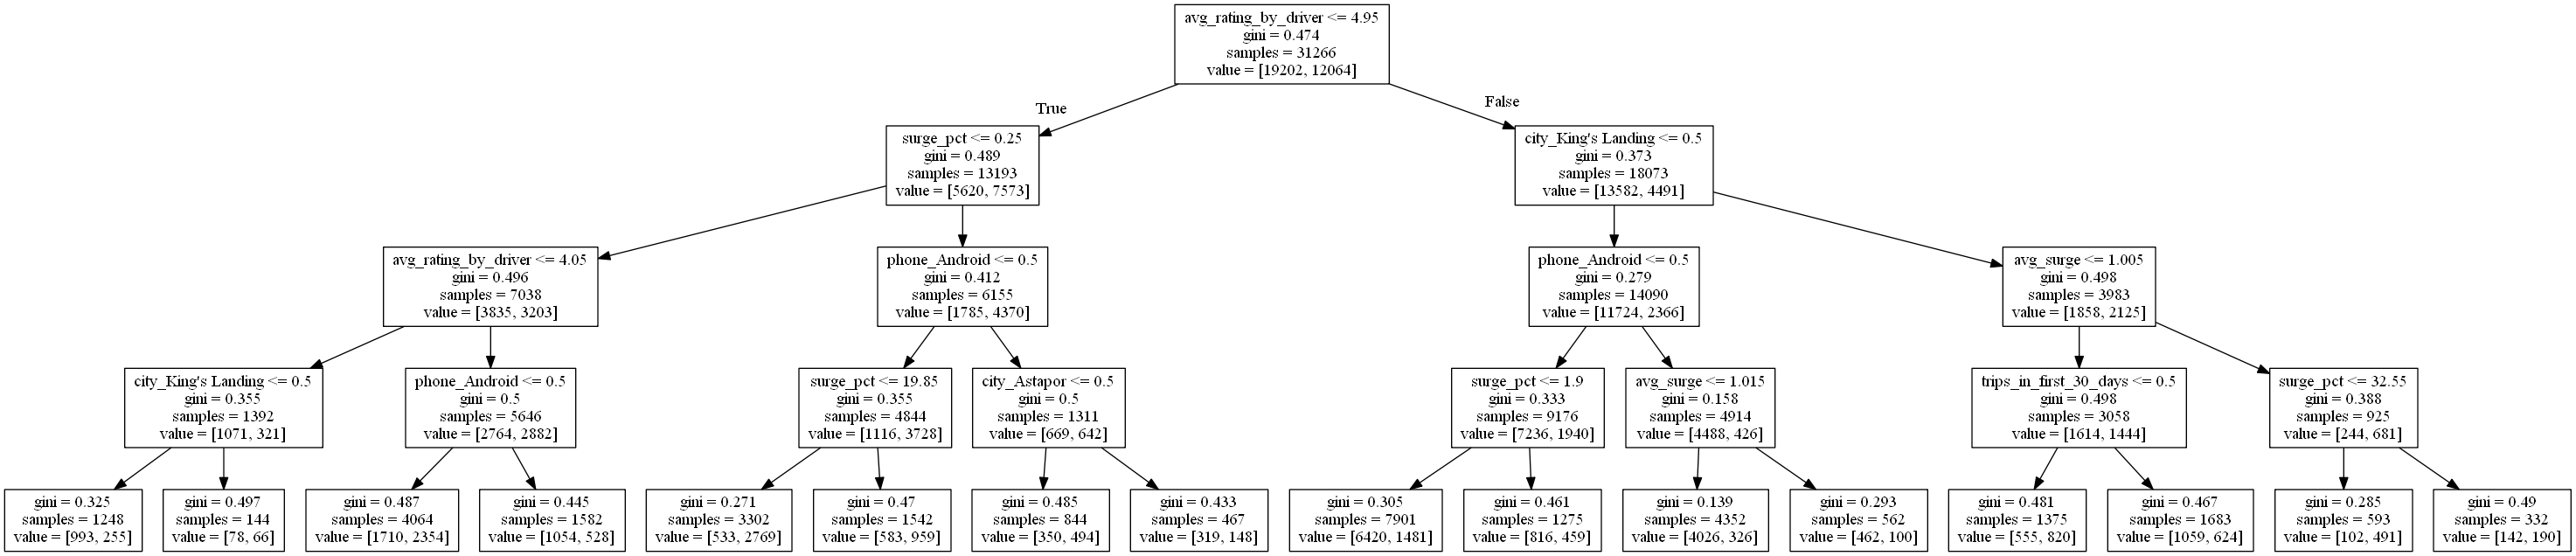

In [40]:
# Write the decision tree to a file
from sklearn.externals.six import StringIO 
from sklearn import tree
import pydotplus
import os     
from graphviz import Graph

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

dot_data = StringIO() 
tree.export_graphviz(final_clf, out_file=dot_data, feature_names=list(train.columns)) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#g = Graph(format='png')
#g.save(filename='tree.png')
graph.write_pdf("tree.pdf")
#graph1 = pydotplus.graphviz.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

We now have a model that is about 74% accurate and does a fairly good job of determining the difference between a retained and not retained user as shown by the confusion matrix. In addition, we may have increased accuracy by allowing the tree to grow further, but this reduces interpretability significantly. Looking at the tree, we see we have the most predictive features near the top of the tree. We can quantify how important these features are:

In [41]:
# Find feature importances
feature_importance = pd.DataFrame(final_clf.feature_importances_).T
feature_importance.columns = list(train.columns)
feature_importance

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,0.0,0.461056,0.0,0.028204,0.159222,0.019828,0.0,0.011149,0.217964,0.0,0.102576,0.0,0.0,0.0


Again, we see the most predictive features are near the top of the visualized tree as we expected. The top 3 most predictive features, from most to least, are avg_rating_by_driver, city_King's_Landing, and surge_pct. 
  
In terms of model validity, this model is somewhat valid. I don't believe this data is appropriate for the task at hand since we have data for all 6-7 months of user activity and the resulting retention label. If we really want to find early predictors of retention, we should have had user activity up to January, no data for 6 months, and then apply retention labels to build a model to determine whether a user may still be riding with Ultimate after 6 months. This model may be good for determining whether a user is retained, but, since we already have all the data, we essentially know whether a user is retained as of right now by looking at the last date of activity.

### Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

To improve longterm rider retention, Ultimate might want to focus on the top predictors of model performance:  
1. <b>avg_rating_by_driver</b>: This indicates that riders with less that or equal to rating 4.95 tend to retain more. This is probabily because riders with an extremely high rating do not ride very often and, in turn, do not get rated very often.  
2. <b>city_King's_Landing</b>: This indicates that riders not from King's Landing tend to be retained more. It is possible that something is happening in this city with drivers or users that is not properly incentivizing retention.  
3. <b>surge_pct</b>: This indicates that users that take less than or equal to 25% of their trips with a surge multipler greater than 1 tend to be retained more. This could signify that surges are too high and could use a reduction to increase user retention.